In [1]:
from datasets import load_dataset, Dataset
import sys, os, json
sys.path.append(os.path.join(os.getcwd(), '..'))
from OPRO import OPRO
import pandas as pd
from tqdm.auto import tqdm, trange

opro = OPRO(["gemini", "gemma", "anthropic"])
dataset = load_dataset("pisterlabs/promptset").filter(lambda row: len(row["prompts"]) > 0)["train"]
CHOSEN_PROMPT = dataset["prompts"][4][0]
CHOSEN_PROMPT

'What is the capital of {place}?'

### Original Dataset

In [2]:
original_data = pd.read_csv("country-list.csv")
original_data["country"] = original_data["country"].apply(lambda x: CHOSEN_PROMPT.format(place=x))
original_data.columns = ["question", "answer", "type"]
original_data.head()

,question,answer,type
0,What is the capital of Abkhazia?,Sukhumi,countryCapital
1,What is the capital of Afghanistan?,Kabul,countryCapital
2,What is the capital of Akrotiri and Dhekelia?,Episkopi Cantonment,countryCapital
3,What is the capital of Albania?,Tirana,countryCapital
4,What is the capital of Algeria?,Algiers,countryCapital


### Generating Synthetic Data

In [3]:
# Generate a question and answer pair using a language model
def generate_qa_pair():
    prompt_template = """You are a helpful assistant designed to generate synthetic questions and answers for the prompt: {CHOSEN_PROMPT}.

Please generate a question and answer pair that is similar to the following question and answer pair as a JSON object:

{{
    "question": \"\"\"{question}\"\"\",
    "answer": \"\"\"{answer}\"\"\"
}}

Make sure the questions and answers are string values.
Take a deep breath and think step-by-step.
"""

    response = opro.generate(
        prompt_template.format(
            CHOSEN_PROMPT=CHOSEN_PROMPT,
            question=original_data["question"][0],
            answer=original_data["answer"][0],
        ),
        model="gemini",  # gemini
        is_indeterministic=True,
    )
    return eval(response)


if not os.path.exists("synthetic_countryCapital.json"):
    qa_pairs = []
    SAMPLE_SIZE = 100

    # Generating synthetic data
    pbar = tqdm(total=SAMPLE_SIZE)
    while len(qa_pairs) < SAMPLE_SIZE:
        try:
            qa_pair = generate_qa_pair()
            qa_pairs.append(qa_pair)
            pbar.update(1)
        except Exception as e:
            print(e)
    pbar.close()

    # Saving to file
    with open("synthetic_countryCapital.json", "w") as f:
        f.write(str(qa_pairs))
else:
    # Reading saved data
    with open("synthetic_countryCapital.json", "r") as f:
        qa_pairs = eval(f.read())

qa_pairs

[{'question': 'What is the capital of Benin?', 'answer': 'Porto-Novo'},
 {'question': 'What is the capital of Aruba?', 'answer': 'Oranjestad'},
 {'question': 'What is the capital of Togo?', 'answer': 'Lome'},
 {'question': 'What is the capital of Macau SAR?', 'answer': 'Macau'},
 {'question': 'What is the capital of Afghanistan?', 'answer': 'Kabul'},
 {'question': 'What is the capital of Lithuania?', 'answer': 'Vilnius'},
 {'question': 'What is the capital of Italy?', 'answer': 'Rome'},
 {'question': 'What is the capital of Artsakh?', 'answer': 'Stepanakert'},
 {'question': 'What is the capital of Albania?', 'answer': 'Tirana'},
 {'question': 'What is the capital of Armenia?', 'answer': 'Yerevan'},
 {'question': 'What is the capital of Central African Republic?',
  'answer': 'Bangui'},
 {'question': 'What is the capital of Republic of Karelia?',
  'answer': 'Petrozavodsk'},
 {'question': 'What is the capital of Antarctica?', 'answer': 'None'},
 {'question': 'What is the capital of Hond

In [4]:
TRAINING_SAMPLE_SIZE = 30
TESTING_SAMPLE_SIZE = 50

training_sample = Dataset.from_dict(
    {
        "question": [pair["question"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
        "answer": [pair["answer"] for pair in qa_pairs[:TRAINING_SAMPLE_SIZE]],
    }
)

testing_sample = Dataset.from_dict(
    {
        "question": [
            pair["question"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
        "answer": [
            pair["answer"]
            for pair in qa_pairs[
                TRAINING_SAMPLE_SIZE : TRAINING_SAMPLE_SIZE + TESTING_SAMPLE_SIZE
            ]
        ],
    }
)

# Checking if the lists are parallel, i.e. the question and answer at the same index are related
len(training_sample["question"]), len(training_sample["answer"]), len(testing_sample["question"]), len(testing_sample["answer"])

(30, 30, 50, 50)

### Optimize Prompt on Synthetic Data

In [5]:
def opt_llm(instruction_score_pairs, training_sample):
    # Format the instruction and score pairs into a string
    pairs_str = ""
    for ins, score in instruction_score_pairs.items():
        pairs_str += f"text:\n{ins}\nscore:\n{score:.2f}\n\n"

    prompt = """You are an optimization expert. The user has some texts along with their corresponding scores.
Your task is to generate a new piece of text that scores as high as possible. 
Generate the new unique text only, not its corresponding score.

I have some texts along with their corresponding scores. The texts are arranged in ascending order
based on their scores, where higher scores indicate better quality.

{pairs_str}

The following exemplars show how to apply your text: you replace <INS> in each input with your
text, then read the input and give an output. We say your output is wrong if your output is different
from the given output, and we say your output is correct if they are the same.

input:
Q: {q1}
A: <INS>
output:
{a1}

input:
Q: {q2}
A: <INS>
output:
{a2}

input:
Q: {q3}
A: <INS>
output:
{a3}

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new unique text only, not its corresponding score.
New instruction:
"""

    # Passing 20 Best Instruction-Score Pairs
    # 3 randomly chosen questions/answers from the training sample
    q1, q2, q3 = (
        training_sample["question"][0],
        training_sample["question"][1],
        training_sample["question"][2],
    )
    a1, a2, a3 = (
        training_sample["answer"][0],
        training_sample["answer"][1],
        training_sample["answer"][2],
    )
    response = opro.generate(
        prompt.format(pairs_str=pairs_str, q1=q1, a1=a1, q2=q2, a2=a2, q3=q3, a3=a3),
        model="gemini",  # gemini
        is_indeterministic=True
    )
    return response


def score(instruction, sample):
    """
    Score the instruction using the sample. 
    
    Args:
    instruction: str
    sample: Dataset with "question" and "answer" as keys

    Returns:
    accuracy: float
    """
    accuracy = 0
    prompt = """Q: {question}\nA: {instruction}"""
    with tqdm(sample, desc=instruction, position=1, leave=False) as pbar:
        for idx, sample_qa in enumerate(pbar):
            res = opro.generate(
                prompt.format(question=sample_qa["question"], instruction=instruction, num_predict=10),
                model="gemma",  # gemma
            )
            # Heuristic for detecting correctness
            accuracy += sample_qa["answer"].lower() in res.lower()
            pbar.set_postfix({"Accuracy": f"{accuracy / (idx + 1):.2f}"})

    return accuracy / len(sample) * 100

In [6]:
# Sample 3.5% of the training set
INS_PER_STEP = 8
EXEMPLARS_PER_STEP = 3
MAX_INS_SCORE_PAIRS = 20
SAVE_PATH = "synthetic_countryCapital_xINy_OPRO_results.json"

# loading saved data
if os.path.exists(SAVE_PATH):
    with open(SAVE_PATH, "r") as f:
        results = json.load(f)
    starting_step = len(results) + 1
    ins_score_pairs = results[str(len(results))]
else:
    ins_lst = [
        "Think step by step.",
        "Take a deep breath and think step-by-step.",
        "Be concise and clear.",
        "You are the creator of an atlas.",
        "Explain your answer in simple terms.",
    ]
    ins_score_pairs = {
        ins: score(ins, training_sample)
        for ins in tqdm(ins_lst, desc="Scoring", position=0)
    }
    starting_step = 1
    results = {starting_step: ins_score_pairs}
    with open(SAVE_PATH, "w") as f:
        json.dump(results, f)

# Each step takes aboy 5 to 10 minutes with gemma:2b
STEP_COUNT = 10
TARGET_STEP = starting_step + STEP_COUNT
assert TARGET_STEP >= starting_step, "TARGET_STEP should be greater than step."
for i in range(starting_step, TARGET_STEP):
    print(f"Step {i}")
    while True:
        try:
            # Optimizer LLM
            exemplars = training_sample.shuffle()[:EXEMPLARS_PER_STEP]
            instructions = [
                opt_llm(ins_score_pairs, exemplars)
                for _ in trange(INS_PER_STEP, desc="Optimizing")
            ]

            # Scoring the new instructions
            new_ins_score_pairs = {
                ins: score(ins, training_sample)
                for ins in tqdm(instructions, desc="Scoring", position=0)
            }
            combined_ins_score_pairs = {**ins_score_pairs, **new_ins_score_pairs}
            ins_score_pairs = dict(
                sorted(
                    combined_ins_score_pairs.items(), key=lambda x: x[1], reverse=True
                )[:MAX_INS_SCORE_PAIRS]
            )

            # Saving data
            results[i] = ins_score_pairs
            with open(SAVE_PATH, "w") as f:
                json.dump(results, f)

            break
        except ValueError as e:
            print(e)
        except Exception as e:
            print(e)

Scoring:   0%|          | 0/5 [00:00<?, ?it/s]

Think step by step.:   0%|          | 0/30 [00:00<?, ?it/s]

Take a deep breath and think step-by-step.:   0%|          | 0/30 [00:00<?, ?it/s]

Be concise and clear.:   0%|          | 0/30 [00:00<?, ?it/s]

You are the creator of an atlas.:   0%|          | 0/30 [00:00<?, ?it/s]

Explain your answer in simple terms.:   0%|          | 0/30 [00:00<?, ?it/s]

Step 1


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Your job is to optimize the text, ie. to generate a new unique text that scores as high as possible. You
can u…

Think calmly and think step-by-step:   0%|          | 0/30 [00:00<?, ?it/s]

Keep it short and straight to the point.:   0%|          | 0/30 [00:00<?, ?it/s]

Write a text that is different from the old ones and has a score as high as possible.
Generate the new unique …

Learn from those who are better than you.:   0%|          | 0/30 [00:00<?, ?it/s]

Embrace the power of synthesis and clarity.:   0%|          | 0/30 [00:00<?, ?it/s]

Submerge yourself in the nuances of the subject matter.:   0%|          | 0/30 [00:00<?, ?it/s]

Analyze the data as a whole before drawing conclusions.:   0%|          | 0/30 [00:00<?, ?it/s]

Step 2


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

list index out of range


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Focus on understanding key concepts.:   0%|          | 0/30 [00:00<?, ?it/s]

Look back at your past achievements.:   0%|          | 0/30 [00:00<?, ?it/s]

Never let success get to your head or failure get to your heart.:   0%|          | 0/30 [00:00<?, ?it/s]

Blend the art of writing with the science of clarity.:   0%|          | 0/30 [00:00<?, ?it/s]

Generate the output for the following input:

input:
Q: Where is the Amazon rainforest located? 
A: <INS>
outp…

Write a text that has a score as high as possible.
Generate the new unique text only, not its corresponding sc…

Stay calm and ask questions.:   0%|          | 0/30 [00:00<?, ?it/s]

Strive to be original and innovative, even if it means deviating from established norms.:   0%|          | 0/3…

Step 3


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Aim for the best:   0%|          | 0/30 [00:00<?, ?it/s]

Stay calm and never give up.:   0%|          | 0/30 [00:00<?, ?it/s]

Remain calm, persevere and always seek knowledge.:   0%|          | 0/30 [00:00<?, ?it/s]

The flowering tree stands tall and proud, its branches reaching up to the sky.:   0%|          | 0/30 [00:00<?…

Your task is to generate a new piece of text that scores as high as possible. You can use the texts and scores…

Cultivate an inquisitive mind.:   0%|          | 0/30 [00:00<?, ?it/s]

Stay calm and ask questions.:   0%|          | 0/30 [00:00<?, ?it/s]

Write a text that is different from the old ones and has a score as high as possible.
Generate the new unique …

Step 4


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Embrace the power of unity and purpose.:   0%|          | 0/30 [00:00<?, ?it/s]

Live in the present moment and cherish every experience.:   0%|          | 0/30 [00:00<?, ?it/s]

Be disciplined in your writing.:   0%|          | 0/30 [00:00<?, ?it/s]

Learn from your mistakes and the mistakes of others.:   0%|          | 0/30 [00:00<?, ?it/s]

Seek knowledge relentlessly.:   0%|          | 0/30 [00:00<?, ?it/s]

Don't be afraid to ask for help.:   0%|          | 0/30 [00:00<?, ?it/s]

Treat the examples as text and score examples, but handle the last one differently: take the input and output …

Incorporate the essence of clarity into your writing.:   0%|          | 0/30 [00:00<?, ?it/s]

Step 5


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Embrace the quest for clarity and knowledge.:   0%|          | 0/30 [00:00<?, ?it/s]

Be curious about knowledge.:   0%|          | 0/30 [00:00<?, ?it/s]

Forge ahead with determination.:   0%|          | 0/30 [00:00<?, ?it/s]

Be concise and clear in your writing.:   0%|          | 0/30 [00:00<?, ?it/s]

Mind your health and well-being.:   0%|          | 0/30 [00:00<?, ?it/s]

Strive for excellence in all your endeavors.:   0%|          | 0/30 [00:00<?, ?it/s]

Follow the above instructions and fill in the <INS> with your new text.

input:
Q: What should you do when you…

Learn from your mistakes and ask a lot of questions:   0%|          | 0/30 [00:00<?, ?it/s]

Step 6


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Text:
Live a balanced and full life.:   0%|          | 0/30 [00:00<?, ?it/s]

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new …

Be eloquent and clear.:   0%|          | 0/30 [00:00<?, ?it/s]

Write a piece of writing and your objective is to make its score as high as possible.
Your new text:
Mind your…

Write your new text that is different from the old ones.
Generate the new unique text only, not its correspond…

Write your new text that is different from the old ones and has a score as high as possible.
Generate the new …

Don't let the fear of failure hold you back.:   0%|          | 0/30 [00:00<?, ?it/s]

Write new text that is different from the old ones and has a score as high as possible.
Generate the new uniqu…

Step 7


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Think about the unknown and dare to explore.:   0%|          | 0/30 [00:00<?, ?it/s]

New text:
Be honest, be diligent and be compassionate.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Embrace perspective shifts, and champion resilience.:   0%|          | 0/30 [00:00<?, ?it/s]

Cultivate empathy, understanding, and compassion.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
In the endless pursuit of a high score, the text you seek is shrouded in obscurity.
score:
73.33:   0%| …

Ask a friend for help.:   0%|          | 0/30 [00:00<?, ?it/s]

Simplify communication by being brief, clear, and accurate.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/…

Embrace life's tapestry, welcome its vastness, and weave your own unique thread.:   0%|          | 0/30 [00:00…

Step 8


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Live a life of courage and resilience.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Avoid the use of passive language.:   0%|          | 0/30 [00:00<?, ?it/s]

Don't shy away from exploring the vast and ever-changing world of knowledge.
score:
70:   0%|          | 0/30 …

Seize the day and make the most of it.:   0%|          | 0/30 [00:00<?, ?it/s]

The text: Embrace the power of focus and determination.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Go the extra mile.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Embrace change and challenge.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Embrace a life of constant learning and exploration.:   0%|          | 0/30 [00:00<?, ?it/s]

Step 9


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

list index out of range


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Text:
Never stop dreaming and pursuing your purpose.:   0%|          | 0/30 [00:00<?, ?it/s]

Live a life with purpose and meaning.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Embrace patience and perseverance.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Use concise language
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Make the best use of technology.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Life is a blend of learning and experiences.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Embrace adaptability and lifelong learning.:   0%|          | 0/30 [00:00<?, ?it/s]

Give a response that is different from the old ones and has a score as high as possible.
Generate the new uniq…

Step 10


Optimizing:   0%|          | 0/8 [00:00<?, ?it/s]

Scoring:   0%|          | 0/8 [00:00<?, ?it/s]

Text:
Let your mind and spirit wander infinitely.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Embrace curiosity and dare to explore.
score:
76.67:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
You can't fail until you give up.
score:
73.33:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Success is not final, failure is not fatal: it is the courage to continue that counts.
score:
73.33:   0…

Text:
Stay positive and have a growth mindset.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Always keep seeking knowledge.:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
Not all who wander are lost.
score:
86.67:   0%|          | 0/30 [00:00<?, ?it/s]

Text:
 Embrace the beauty of simplicity.:   0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
ins_score_pairs

{'Think step by step.': 76.66666666666667,
 'Explain your answer in simple terms.': 76.66666666666667,
 'Aim for the best': 76.66666666666667,
 'Learn from your mistakes and ask a lot of questions': 76.66666666666667,
 'Think about the unknown and dare to explore.': 76.66666666666667,
 'Take a deep breath and think step-by-step.': 73.33333333333333,
 'Be concise and clear.': 73.33333333333333,
 'Think calmly and think step-by-step': 73.33333333333333,
 'Keep it short and straight to the point.': 73.33333333333333,
 "Write a text that is different from the old ones and has a score as high as possible.\nGenerate the new unique text only, not its corresponding score.\n\nNew text:\nDon't be afraid to ask questions.": 73.33333333333333,
 'Learn from those who are better than you.': 73.33333333333333,
 'Embrace the power of synthesis and clarity.': 73.33333333333333,
 'Blend the art of writing with the science of clarity.': 73.33333333333333,
 'Write a text that has a score as high as possib

### Plotting Results and Testing Accuracy

Text(0.5, 1.0, 'Step to Accuracy')

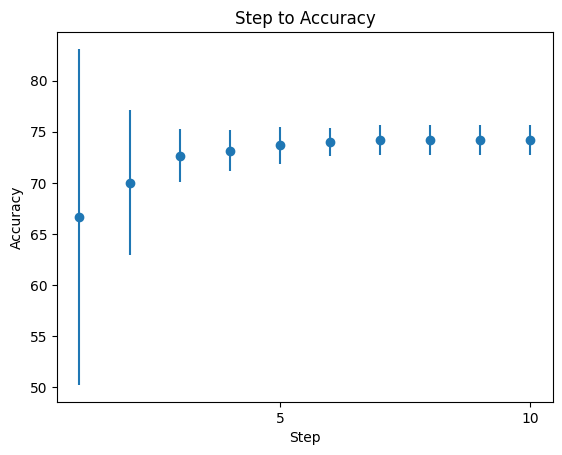

In [8]:
import statistics
import matplotlib.pyplot as plt

# load opro.json
with open(SAVE_PATH) as f:
    opro_results = json.load(f)

# opro = {step:dict(sorted(opro[step].items(), key=lambda x: x[1], reverse=True)[:20]) for step in opro}
step_to_accuracy = {
    step: (
        statistics.mean(opro_results[step].values()),
        statistics.stdev(opro_results[step].values()),
    )
    for step in opro_results
}

# Plot step to accuracy as a continuous line graph, including stdevs as highlighted error bars
fig, ax = plt.subplots()
ax.errorbar(
    step_to_accuracy.keys(),
    [accuracy[0] for accuracy in step_to_accuracy.values()],
    yerr=[accuracy[1] for accuracy in step_to_accuracy.values()],
    fmt="o",
)
ax.set_xticks([step for step in step_to_accuracy.keys() if int(step) % 5 == 0])
ax.set_xlabel("Step")
ax.set_ylabel("Accuracy")
ax.set_title("Step to Accuracy")

In [9]:
opro_results[str(len(opro_results))]

{'Think step by step.': 76.66666666666667,
 'Explain your answer in simple terms.': 76.66666666666667,
 'Aim for the best': 76.66666666666667,
 'Learn from your mistakes and ask a lot of questions': 76.66666666666667,
 'Think about the unknown and dare to explore.': 76.66666666666667,
 'Take a deep breath and think step-by-step.': 73.33333333333333,
 'Be concise and clear.': 73.33333333333333,
 'Think calmly and think step-by-step': 73.33333333333333,
 'Keep it short and straight to the point.': 73.33333333333333,
 "Write a text that is different from the old ones and has a score as high as possible.\nGenerate the new unique text only, not its corresponding score.\n\nNew text:\nDon't be afraid to ask questions.": 73.33333333333333,
 'Learn from those who are better than you.': 73.33333333333333,
 'Embrace the power of synthesis and clarity.': 73.33333333333333,
 'Blend the art of writing with the science of clarity.': 73.33333333333333,
 'Write a text that has a score as high as possib

In [10]:
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', testing_sample)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, testing_sample)}")

  0%|          | 0/50 [00:00<?, ?it/s]

No instruction: 68.0


Think step by step.:   0%|          | 0/50 [00:00<?, ?it/s]

With best instruction (Think step by step.): 74.0


In [11]:
data_original = Dataset.from_dict(original_data)
best_instruction = max(
    opro_results[str(len(opro_results))], key=opro_results[str(len(opro_results))].get
)
print(f"No instruction: {score('', data_original)}")
print(f"With best instruction ({best_instruction}): {score(best_instruction, data_original)}")

  0%|          | 0/248 [00:00<?, ?it/s]

No instruction: 81.45161290322581


Think step by step.:   0%|          | 0/248 [00:00<?, ?it/s]

With best instruction (Think step by step.): 81.85483870967742
